# 第一步

## 参考的代码

In [6]:
# coding=utf8

import urllib2

import string

import traceback

import urllib

import re

import chardet

import random

from utils.FileUtils import writeContentStr2File, writeAppend2File

from utils.word.Alphabet import cleanWord

from fake_useragent import UserAgent

# 设置多个user_agents，防止百度限制IP
ua = UserAgent()
user_agents = [ua.random for i in range(6)]


def baidu_search(keyword, pn):
    p = {'word':  keyword}
#      url =  ("http://www.baidu.com/s?"+urllib.urlencode(p)+"&pn={0}&cl=3&rn=100").format(pn)

    url = ("https://wenku.baidu.com/search?" +
            urllib.urlencode(p)+"&pn={0}&cl=3&rn=100").format(pn)

    print(url)

    res = urllib2.urlopen(url)

    html = res.read()

#      print html

    return html


def getList(regex, text):
    arr = []
    res = re.findall(regex, text)
    if res:
        for r in res:
            arr.append(r)
    return arr


def getMatch(regex, text):
    res = re.findall(regex, text)

    if  res:

         return res[0]

    return""


def clearTag(text):

    p  = re.compile(u'<[^>]+>')

    retval = p.sub("",text)

    return  retval

 

def downloadurl(url):
    domain=urllib2.Request(url)

#     domain=urllib2.Request(url)

    r=random.randint(0,9)

    domain.add_header('User-agent',  user_agents[r])

    domain.add_header('connection','keep-alive')

    response=urllib2.urlopen(domain)     

    data = response.read()

    return  data


def geturl(keyword):
    for  page in range(10):
        pn=page*10
        html = baidu_search(keyword,pn)
        content = html
        writeContentStr2File(content, "baidu.result.html", "GBK")
        postfix = u"https://wenku.baidu.com/view"
        arrList = getList(u"href=\""+  postfix + u"(.*?)\"",  content)
        for item in  arrList:
            url = postfix + item
            url = url.replace("?from=search","")
            print(url)
            writeAppend2File(url+'\n', "wenku.doc.url.txt")

geturl('历年英语真题')

ModuleNotFoundError: No module named 'urllib2'

## 自己琢磨出来的

**给定关键字，搜索百度文库，并按页解析出要下载的文档url**

1、根据关键字拼出来搜索结果URL

2、通过https访问百度文库获取搜索结果

3、解析搜索结果，将文库的文档地址与文档名保存到一个csv中


In [8]:
# coding=utf8
import urllib
import requests
import re
import pandas as pd

class Csv_downloader():
    keyword = ''
    num_pages = 0
    
    def __init__(self,keyword,num_pages):
        self.keyword = keyword
        self.num_pages = num_pages   # 查找的总页数

    def get_num(self):
        '''
        获取查找到的所有文档数量
        params:num_docs.group(1)：相关文档数量
        '''
        # 获取HTML文档
        html = self.get_html(0)

        # 使用正则表达式匹配数量内容
        pattern = r'.*找到相关文档约(.*)篇.*'    # 正则表达式
        num_docs = re.search(pattern, html)     # 查找
        print("总共提取了{}份文档".format(num_docs.group(1)))
        return num_docs.group(1)     # 返回查找结果

    def get_html(self, page):
        '''
        获取html
        params:page：所要获取的HTML代码所在的页数
        params:html：网页源码
        '''
        # 合成网页url
        head_url = r'https://wenku.baidu.com/search?'
        kw = {'word': self.keyword}    # 得到关键字字典
        wd = urllib.parse.urlencode(kw)   # 对输入的关键字编码
        url = head_url+wd+'&org=0&fd=0&lm=0&od=0&'+'pn='+str(page*10)   # 合成网页url

        # 读取html文件
        response = requests.get(url)   # 获取网页源代码
        html = response.text.encode('latin1').decode('gbk')  # 避免中文乱码
        return html

    def doc_info(self,html):
        '''
        获取所有文档的网址、id和标题
        params:html：网页的HTML文档
        params:href_title：列表，每一个成员为一个列表[title,href]
        '''
        # 正则表达式(注意里面的？.等符号的使用)
        pattern_href = r'<a href="https://wenku.baidu.com/view/(.*).html\?from=search"'
        pattern_title = r'                        title="(.*)"'
        # 匹配文件id
        data_edocids = re.findall(pattern_href,html)
        # 匹配title
        title = re.findall(pattern_title,html)

        # 用网址与标题组建列表
        try:
            if len(data_edocids) == len(title):
                href_title,href = [0]*len(data_edocids),[0]*len(data_edocids)
                # 存入列表
                for index in range(len(data_edocids)):
                    href[index] = 'https://wenku.baidu.com/view/{}.html?from=search'.format(data_edocids[index])
                    href_title[index] = [title[index],data_edocids[index],href[index]]     
#             else:
#                 print("本页获取的文档数量出错!文档标题可能有误，具体标题参见下载的文档")
        except:
            print("本页获取的文档数量出错!文档标题可能有误，具体标题参见下载的文档")
        return href_title

    def combine_info(self):
        '''
        合并所有文档的标题与网址
        params:href_title：字典形式的信息集合体
        '''
        href_title = []
        for page in range(self.num_pages):   # 一页一页地获取
            # 获取第page页的网页源码
            html = self.get_html(page)
            # 匹配所有文档的url与title,href_title为列表，包含网址href和标题title
            href_title += self.doc_info(html)  
        return href_title
    
    def get_csv(self):
        '''
        main函数---将获取的文档存入csv文件中去
        keyword:你想要搜索的内容
        num_pages:你想要获取文档的页数
        '''
        # 提取所有的文档地址与标题
        href_title = self.combine_info()
        print("总共提取了{}份文档".format(len(href_title)))

        # 将信息转为DataFrame结构,herf_title为二维列表结构
        index_name = ["第{}个".format(i) for i in range(1,len(href_title)+1)]
        df = pd.DataFrame(columns=['标题','id','网址'],index=index_name,data=href_title)

        # 存为csv文件,encoding='utf_8_sig'是为了避免中文乱码
        try:
            df.to_csv("文档标题与网址.csv",encoding='utf_8_sig')
            print("文件保存成功！")
        except:
            print("文件保存失败┭┮﹏┭┮")


csvdownloader1 = Csv_downloader('随机过程',2)

csvdownloader1.get_csv()


总共提取了20份文档
文件保存失败┭┮﹏┭┮


# 第二步

## selenium驱动的安装过程

    Chrome浏览器版本号查找：chrome://settings/help

[ChromeDriver与Chrome版本对应参照表请点击此处](https://blog.csdn.net/BinGISer/article/details/88559532)

[ChromeDriver下载请点击此处](https://npm.taobao.org/mirrors/chromedriver/)

[执行selenium报错unknown error: cannot find Chrome binary 解决方法](https://blog.csdn.net/flower_drop/article/details/81129106)

[解决使用selenium库出现的“Message: 'chromedriver' executable may have wrong permissions”问题](https://blog.csdn.net/zhouzying/article/details/79988811)




  注：驱动文件chromedriver的路径应添加进环境变量，chrome浏览器才能被python第三方库selenium调用
  
&emsp;**windows下设置环境变量的方法：**

&emsp;win+r，输入sysdm.cpl，点击确定，出现如下对话框：
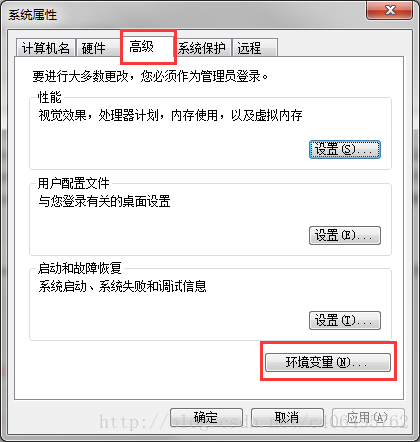

选择高级->环境变量。在系统变量的Path变量中，添加驱动文件路径即可(注意：分号)。

&emsp;Linux的环境变量也好设置，在~/.bashrc文件中export即可，记得source ~/.bashrc。

&emsp;当然，你不设置环境变量也是可以的，程序可以这样写：

    from selenium import webdriver
    browser = webdriver.Chrome('path\to\your\chromedriver.exe')
    browser.get('http://www.baidu.com/')

&emsp;上面的path\to\your\chromedriver.exe 是你的chrome驱动文件位置，可以使用绝对路径。

## 动态爬取文件 

**一种简单的实现方法**

1、读取保存的CSV文件，读取结果保存到DataFrame里面去

2、将文档网址传入第三方网站，捕获下载请求并下载文档，以title命名文档

3、将下载的内容存放到一个文件夹里面，并将整个文件夹命名为keyword

In [ ]:
import pandas as pd
import requests

response = requests.get()

# url: https://wenku.baidu.com/view/ca637241d15abe23492f4d79.html?from=search
# type: pdf
# t: 1571490295000
# sign: 9c0ba0fa06e39157afab02d60eee680a

**思路**

1、读取保存的CSV文件，读取结果保存到DataFrame里面去

2、

[参考文章1(点击可访问):Python3网络爬虫(九)：使用Selenium爬取百度文库word文章](https://blog.csdn.net/c406495762/article/details/72331737?utm_source=app)

[参考文章2(点击可访问):爬虫一下，百度付费文档轻松得，不用花钱，不用花钱，不用花钱！！！](https://cloud.tencent.com/developer/article/1103348)

[参考文章3(点击可访问):python下载某网站收费文档（二）——配合mitmproxy全自动版](https://blog.csdn.net/MissYourKiss/article/details/100595382)

[在爬虫时，如何设置selenium，启动时不弹出浏览器](https://segmentfault.com/q/1010000014525206/a-1020000014526036)



[百度文库搜索‘随机过程’的网址](https://wenku.baidu.com/search?word=%E9%9A%8F%E6%9C%BA%E8%BF%87%E7%A8%8B&org=0&fd=0&lm=0&od=0&pn=0)

**代码中涉及的一些内容：**

1、[assert断言语句的使用](https://blog.csdn.net/u011846143/article/details/78554130)

2、

conda下载外网的包加速：
运行以下代码即可

    conda config --add channels https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main/conda 
    config --add channels https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/free/conda 
    config --add channels https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/conda-forge/conda 
    config --set show_channel_urls yes


In [3]:
from selenium import webdriver


# Chromedriver的位置，必须有，不然将无法打开浏览器
path = r'G:\\Manager\\百分百浏览器\\CentBrowser\\Application\\chromedriver.exe'
driver = webdriver.Chrome(path)   # 打开浏览器

# 
URL = r'https://wenku.baidu.com/view/e8b686f5eff9aef8951e0671.html?from=search'
# html = driver.get(URL)
assert "百度文库" in driver.title    # 判断这个确实是真的
elem = driver.find_element_by_name("q")

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys

# path = r'G:\\Manager\\百分百浏览器\\CentBrowser\\Application\\chromedriver.exe'
# driver = webdriver.Chrome(path)
# driver.get("http://www.python.org")
# assert "Python" in driver.title
# elem = driver.find_element_by_name("q")
# elem.send_keys("pycon")
# elem.send_keys(Keys.RETURN)
# print(driver.page_source)



AssertionError: 

## 参照1

In [9]:
#coding=utf-8
import re;
import urllib;
import urllib.request;
 
header = {
    "User-Agent":"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 UBrowser/1.0.370.1388 Safari/537.36", 
}
 
URL_GETBDWKDOC = "http://wenku.baidu.com/play/{0}?pn={1}";   # 获取图片数据的请求网址
URL_BDWK = "http://wenku.baidu.com/view/{0}.html";
 
class BdWkDownloader:
    def __init__(self):
        pass;
        
    def getTotalPages(self, id):
        return int(re.compile(r"totalPageNum'\s*:\s*'(\d+)'").findall(urllib.request.urlopen(URL_BDWK.format(id)).read().decode("gb2312"))[0]);
        
    def download(self, id, dir = "./"):
        num = self.getTotalPages(id);
        print("总共有{}页".format(num))
        for i in range(0, num):
            request = urllib.request.Request(URL_GETBDWKDOC.format(id, i + 1), headers = header);
            data = urllib.request.urlopen(request).read();
            file = open("{0}{1}.{2}".format(dir, i, "swf"), "wb");
            file.write(data[106:]);
            file.close();
            
def main():
    downloader = BdWkDownloader();
    downloader.download("e8b686f5eff9aef8951e0671");
    
main()

总共有78页


## 参照2

In [6]:
import os
import re
import json
import requests
from lxml import etree
import sys
# import tkinter

# 创建文库基类
class BaiduWK(object):
	def __init__(self, url):
		self.title = None
		self.url = url
		self.docType = None
		self.headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.75 Safari/537.36'}
		self.get_response_content(self.url)
		self.get_doc_type_and_title()

	def get_response_content(self, url):
		try:
			response = requests.get(url, headers = self.headers)
			return response.content
		except Exception as e:
			print(e)
			pass
	def get_doc_type_and_title(self):
		# 获取源码
		source_html = self.get_response_content(self.url)
		# 解析源码
		content = source_html.decode('gbk')
		# 获取文档类型
		self.docType = re.findall(r"docType.*?\:.*?\'(.*?)\'\,", content)[0]
		# 获取文档标题
		self.title = re.findall(r"title.*?\:.*?\'(.*?)\'\,", content)[0]

# 创建获取txt的类
class BDWKTXT(BaiduWK):
	def __init__(self, url):
		super().__init__(url)
		self.docId = None
		pass

	def get_txt(self, url):
		# 获取源码
		source_html = self.get_response_content(url)
		content = source_html.decode("gbk")
		# 获取docId
		self.docId = re.findall(r"docId.*?(\w{24}?)\'\,", content)[0]
		# 拼接请求url
		token_url =  "https://wenku.baidu.com/api/doc/getdocinfo?callback=cb&doc_id=" + self.docId
		# 再次请求
		first_json = self.get_response_content(token_url).decode()
		str_first_json = re.match(r'.*?\((\{.*?\})\).*', first_json).group(1)
		# print(str_first_json)
		the_first_json = json.loads(str_first_json)
		md5sum = the_first_json["md5sum"]
		rn = the_first_json["docInfo"]["totalPageNum"]
		rsign = the_first_json["rsign"]
		# print(md5sum,"-->",rn)
		# 请求目标url
		target_url = "https://wkretype.bdimg.com/retype/text/" + self.docId + "?" + md5sum + "&callback=cb" + "&pn=1&rn=" + rn + "&type=txt" +"&rsign=" + rsign

		# https://wkretype.bdimg.com/retype/text/de53bafaf705cc1755270982?md5sum=b89f055e765e6f73db57525bcfc3c2d2&sign=7b385f9cf7&callback=cb&pn=1&rn=12&type=txt

		sec_json = self.get_response_content(target_url).decode()
		# print(type(sec_json),"-->")
		str_sec_json = re.match(r'.*?\(\[(.*)\]\)$', sec_json).group(1)
		str_sec_json += ","
		str_json_list = str_sec_json.split('},')
		result_txt = ""
		# 截取尾部空格
		str_json_list = str_json_list[:-1]
		for str_json in str_json_list:
			str_json += "}"
			pure_dic = json.loads(str_json)
			pure_txt = pure_dic["parags"][0]["c"].strip()
			result_txt += pure_txt

		# 创建文件目录
		try:
			path = "." + os.sep + self.docType
			# print(type(path),"path-->",path)

			os.makedirs(path)
		except Exception as e:
			# print("文件夹%s已存在"%(path))
			pass
		# 创建文件,保存信息
		try:
			file_name = "." + os.sep +self.docType + os.sep + self.title + ".txt"
			with open(file_name, 'w', encoding='utf-8') as f:
				f.write(result_txt)
				print("已经保存为:",self.title + '.txt')
		except Exception as e:
			# print(e)
			pass



# 创建获取word的类
class BDWKDOC(BaiduWK):
	def __init__(self, url):
		super().__init__(url)
		# 保存数据来源url
		self.pure_addr_list = list()

	# 获取数据来源url
	def get_pure_addr_list(self):
		# 获取页面源码
		source_html = self.get_response_content(self.url).decode('gbk')
		# 从源码中批量提取数据url
		all_addr = re.findall(r'wkbos\.bdimg\.com.*?json.*?expire.*?\}',source_html)
		pure_addr_list = list()
		# 获取文档标题
		self.title = etree.HTML(source_html).xpath("//title/text()")[0].strip()
		# 净化数据来源url列表
		for addr in all_addr:
			addr = "https://" + addr.replace("\\\\\\/", "/")
			addr = addr[:-5]
			pure_addr_list.append(addr)
		# 将处理好的url列表保存为全局属性
		self.pure_addr_list = pure_addr_list

		return pure_addr_list
	# 从数据来源的url列表中提取数据
	def get_json_content(self, url_list):
		content = ''
		result = ''
		sum = len(url_list)
		i = 1
		for pure_addr in url_list:
			print("正在下载第%d条数据, 剩余%d条"%(i, sum-i))
			i += 1
			try:
				# 获取json数据
				content = self.get_response_content(pure_addr).decode()
				# 处理json数据
				content = re.match(r'.*?\((.*)\)$', content).group(1)

				# 将json数据中需要的内容提取出来
				all_body_info = json.loads(content)["body"]
				# 遍历获取所有信息,并将信息拼接到一起
				for body_info in all_body_info:
					try:
						result = result + body_info["c"].strip()
						# print(">>",result)
					except Exception as e:
						print(e)
						pass

			except Exception as e:
				print(e)
				pass
		# 创建文件目录
		try:
			path = "." + os.sep + self.docType
			# print(type(path),"path-->",path)

			os.makedirs(path)
		except Exception as e:
			# print("文件夹%s已存在"%(path))
			pass
		# 创建文件,保存信息
		try:
			file_name = "." + os.sep +self.docType + os.sep + self.title + ".txt"
			with open(file_name, 'w', encoding='utf-8') as f:
				f.write(result)
				print("已经保存为:",self.title + '.txt')
		except Exception as e:
			print(e)



# 创建获取ppt的类
class BDWKPPT(BaiduWK):
	def __init__(self, url):
		self.all_img_url = list()
		super().__init__(url)
	
	# 获取json数据保存文件
	def get_ppt_json_info(self):
		# 获取源文件
		ppt_source_html = self.get_response_content(self.url)
		# 解析源文件
		content = ppt_source_html.decode('gbk')
		# print("-->",len(content))
		# 测试
		with open("test.html", "w") as f:
			f.write(content)

		# 获取文档Id
		self.docId = re.findall(r"docId.*?(\w{24}?)\'\,", content)[0]
		# 拼接请求json的接口
		source_json_url = 'https://wenku.baidu.com/browse/getbcsurl?doc_id=%s&type=ppt&callback=zhaozhao'%self.docId
		# 获取字符串类型的json数据
		str_source_json = self.get_response_content(source_json_url).decode()
		# 处理字符串类型的json数据,使其成为标准格式
		pure_str_source_json = re.match(r'.*?\((.*?)\)', str_source_json).group(1)
		# 将字符串json转为可处理的正式json
		source_json = json.loads(pure_str_source_json)

		# 遍历字典中的数据类型list
		for j in source_json['list']:
			# 创建临时列表
			temp_num_url = list()
			# 将url和page拼接到列表中
			temp_num_url.append(j["zoom"])
			temp_num_url.append(j["page"])
			# 将列表信息添加到全局变量中
			self.all_img_url.append(temp_num_url)

		# 建立文件夹
		try:
			os.makedirs("./ppt/%s"%(self.title))
		except Exception as e:
			# print("---->>",e)
			pass
		
		for img_url in self.all_img_url:
			# print(img_url)
			print("正在获取第%d页资源(剩余%d页)"%(img_url[1], len(self.all_img_url)-img_url[1]))
			data = self.get_response_content(img_url[0])
			path = "./ppt/%s/%s"%(self.title, str(img_url[1])+'.jpg')
			with open (path, 'wb') as f:
				f.write(data)

		print("写入完毕")



# 运行主程序
def main():
	try:
		url = input("请输入资源所在的网址:")
		docType = BaiduWK(url).docType
	except:
		print("您输入的url,有误请重新输入!")
		os.exit()
	print("类型为","-->",docType)

	if docType == "ppt":

		ppt = BDWKPPT(url)
		print("您将要获取的演示文稿(ppt)名称为:", ppt.title)
		ppt.get_ppt_json_info()

	elif docType == "doc":
		word = BDWKDOC(url)
		print("您将要获取的文档(word)名称为", word.title)
		pure_addr_list = word.get_pure_addr_list()
		word.get_json_content(pure_addr_list)

	elif docType == "pdf":
		pdf = BDWKDOC(url)
		print("您将要获取的PDF名称为:", pdf.title)
		pure_addr_list = pdf.get_pure_addr_list()
		pdf.get_json_content(pure_addr_list)

	elif docType == "txt":

		txt = BDWKTXT(url)
		print("您将要下载的文本文档(txt)名称为:", txt.title)
		txt.get_txt(url)

	else:
		other = BDWKPPT(url)
		print("暂不支持下载%s类型"%(other.docType))
		pass


main()

请输入资源所在的网址:https://wenku.baidu.com/view/fdeb37bd09a1284ac850ad02de80d4d8d15a01e6.html?from=search
类型为 --> doc
您将要获取的文档(word)名称为 随机过程的基本概念和基本类型
已经保存为: 随机过程的基本概念和基本类型 - 百度文库.txt


## 自己码的

In [3]:
#coding=utf-8
import re;
import urllib;
import urllib.request;
import sys 
import os
 
header = {
    "User-Agent":"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 UBrowser/1.0.370.1388 Safari/537.36", 
}
 
URL_GETBDWKDOC = "http://wenku.baidu.com/play/{0}?pn={1}";   # 获取图片数据的请求网址
URL_BDWK = "http://wenku.baidu.com/view/{0}.html";
 
class BdWkDownloader:
    def __init__(self):
        pass;
        
    def getTotalPages(self, id):
        return int(re.compile(r"totalPageNum'\s*:\s*'(\d+)'").findall(urllib.request.urlopen(URL_BDWK.format(id)).read().decode("gb2312"))[0]);
        
    def download(self, id, dir = "./"):
        '''
        下载文件并存放到一个文件夹里面
        params：dir:文件存放的位置，"./"代表当前文件夹
        '''
        num = self.getTotalPages(id)
        print("总共有{}页".format(num))
        
        # 创建文件夹
        try:
            os.makedirs(dir+str(id))
        except Exception as e:
            print("创建文件夹出错，错误为----->",e)
        
        # 将文件保存为swf
        path = dir+str(id)+"/"+"{}.{}"
        for i in range(0, num):
            try:
                request = urllib.request.Request(URL_GETBDWKDOC.format(id, i + 1), headers = header)
                data = urllib.request.urlopen(request).read()
    #             path[i] = dir+str(id)+"/"+"{}.{}".format(i+1,"swf")
                with open(path.format(i+1,"swf"),'wb') as file:
                    file.write(data[106:])
            except Exception as e:
                num -= 1
                print("发送请求时出错")
        
        # 将swf文件转为png，并删除已转换文件
        flag  = "转换正确^_^"
        for i in range(num):
            path_tool = r"C:\Users\cw817615\Desktop\6d8afcbba42b616e91778660b5bb019e\swf2png\swf2img2.exe"
            cmd = path_tool+" "+path.format(i+1,"swf")+" "+path.format(i+1,"png")
            f = os.popen(cmd,'r')
            return_txt = f.read()
            if "Processing" not in return_txt:
                flag  = "swf转png出错┭┮﹏┭┮"
        print(flag)
            
        
            
def main():
    downloader = BdWkDownloader();
    downloader.download("36fe0ccdc4da50e2524de518964bcf84b8d52d2a");
    
main()

# 		for img_url in self.all_img_url:
# 			# print(img_url)
# 			print("正在获取第%d页资源(剩余%d页)"%(img_url[1], len(self.all_img_url)-img_url[1]))
# 			data = self.get_response_content(img_url[0])
# 			path = "./ppt/%s/%s"%(self.title, str(img_url[1])+'.jpg')
# 			with open (path, 'wb') as f:
# 				f.write(data)

# 		print("写入完毕")

总共有4页
创建文件夹出错，错误为-----> [WinError 183] 当文件已存在时，无法创建该文件。: './36fe0ccdc4da50e2524de518964bcf84b8d52d2a'
swf转png出错┭┮﹏┭┮
